<a href="https://colab.research.google.com/github/sethgis/dash_front_end/blob/main/RANDOM_FOREST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from sklearn.ensemble import RandomForestClassifier # classifier
import pandas as pd # handling large data as table sheets
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment

import seaborn as sn

import datetime

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [ ]:
# import plotly.express as px

In [ ]:
# define a number of trees that should be used (default = 500)
est = 500

# how many cores should be used?
# -1 -> all available cores
n_cores = -1

# the remote sensing image you want to classify
img_RS = '/content/drive/MyDrive/VI_20210517.tif'


# training and validation as shape files
validation = '/content/drive/MyDrive/CHECK.geojson'
training = '/content/drive/MyDrive/TRAIN.geojson'



In [ ]:
# what is the attributes name of your classes in the shape file (field name of the classes)?
# attribute = 'class'


# directory, where the classification image should be saved:
classification_image = '/content/drive/MyDrive/classificationLULC_2.tif'

# directory, where the all meta results should be saved:
# results_txt = 'R:\\OwnCloud\\WetScapes\\2020_04_23_HüMo\\results\\results_txt_.txt'

In [ ]:
!pip install geopandas
import geopandas as gpd


In [ ]:
import geopandas as gpd
shapes = gpd.read_file(training)
list(shapes.columns.values)
[u'dip', u'dip_dir', u'cosa', u'sina', 'geometry']
# first features
shapes.head(3)

,crop,mix,crop2,comments,LULC2020,layer,class,sample_t,lulcnum,LU_num,geometry
0,tea,None,None,None,None,VT_kilimo_2021LR_derrick,tea,0,14,14,"MULTIPOLYGON (((34.82352 0.09706, 34.82366 0.0..."
1,tea,None,None,None,None,VT_kilimo_2021LR_derrick,tea,0,14,14,"MULTIPOLYGON (((34.76869 0.09285, 34.76865 0.0..."
2,pasture,None,None,None,None,VT_kilimo_2021LR_derrick,pasture,0,11,11,"MULTIPOLYGON (((34.76115 0.07885, 34.76151 0.0..."


In [ ]:
# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'LU_num'


# directory, where the classification image should be saved:
# classification_image = 'R:\\OwnCloud\\WetScapes\\2020_04_23_HüMo\\results\\HueMo2018_14bands_class_.tif'

# directory, where the all meta results should be saved:
# results_txt = 'R:\\OwnCloud\\WetScapes\\2020_04_23_HüMo\\results\\results_txt_.txt'

In [ ]:
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

Available attributes in the shape file are: ['crop', 'mix', 'crop2', 'comments', 'LULC2020', 'layer', 'class', 'sample_t', 'lulcnum', 'LU_num']


In [ ]:
results_txt = '/content/drive/MyDrive/RESULTS_SAVINGS.txt'

In [ ]:
print('Random Forest Classification', file=open(results_txt, "a"))
print('Processing: {}'.format(datetime.datetime.now()), file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))
print('PATHS:', file=open(results_txt, "a"))
print('Image: {}'.format(img_RS), file=open(results_txt, "a"))
print('Training shape: {}'.format(training) , file=open(results_txt, "a"))
print('Vaildation shape: {}'.format(validation) , file=open(results_txt, "a"))
print('      choosen attribute: {}'.format(attribute) , file=open(results_txt, "a"))
print('Classification image: {}'.format(classification_image) , file=open(results_txt, "a"))
print('Report text file: {}'.format(results_txt) , file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))

In [ ]:
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from sklearn.ensemble import RandomForestClassifier # classifier
import pandas as pd # handling large data as table sheets
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment

import seaborn as sn

import datetime

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [ ]:
src_ds = gdal.Open("/content/drive/MyDrive/VI_20210517.tif")
data = src_ds.ReadAsArray()



In [ ]:
img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [ ]:
row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount

print('Image extent: {} x {} (row x col)'.format(row, col))
print('Number of Bands: {}'.format(band_number))


print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))
print('Number of Bands: {}'.format(band_number), file=open(results_txt, "a"))
print('---------------------------------------', file=open(results_txt, "a"))
print('TRAINING', file=open(results_txt, "a"))
print('Number of Trees: {}'.format(est), file=open(results_txt, "a"))

Image extent: 4868 x 7493 (row x col)
Number of Bands: 4


In [ ]:
# laod training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()

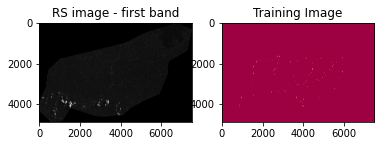

25452 training samples
training data include 17 classes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Our X matrix is sized: (25452, 4)
Our y array is sized: (25452,)


In [ ]:
# Display images
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()

# Number of training pixels:
n_samples = (roi > 0).sum()
print('{n} training samples'.format(n=n_samples))
print('{n} training samples'.format(n=n_samples), file=open(results_txt, "a"))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels), file=open(results_txt, "a"))

# Subset the image dataset with the training image = X
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

In [ ]:
rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=1, n_jobs=n_cores)

# verbose = 2 -> prints out every tree progression
# rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=2, n_jobs=n_cores)



X = np.nan_to_num(X)
rf2 = rf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.8s finished


In [ ]:
print('--------------------------------', file=open(results_txt, "a"))
print('TRAINING and RF Model Diagnostics:', file=open(results_txt, "a"))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100), file=open(results_txt, "a"))


# we can show the band importance:
bands = range(1,img_ds.RasterCount+1)

for b, imp in zip(bands, rf2.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))
    print('Band {b} importance: {imp}'.format(b=b, imp=imp), file=open(results_txt, "a"))

    
# Let's look at a crosstabulation to see the class confusion. 
# To do so, we will import the Pandas library for some help:
# Setup a dataframe -- just like R
# Exception Handling because of possible Memory Error

try:
    df = pd.DataFrame()
    df['truth'] = y
    df['predict'] = rf.predict(X)

except MemoryError:
    print('Crosstab not available ')

else:
    # Cross-tabulate predictions
    print(pd.crosstab(df['truth'], df['predict'], margins=True))
    print(pd.crosstab(df['truth'], df['predict'], margins=True), file=open(results_txt, "a"))

OOB prediction of accuracy is: 57.51610875373252%
Band 1 importance: 0.2351856744937702
Band 2 importance: 0.26353286611129223
Band 3 importance: 0.22905290664422304
Band 4 importance: 0.2722285527507145


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    2.8s finished


predict    1    2    3     4    5     6  ...   13    14    15  16   17    All
truth                                    ...                                 
1        147    0    0     0    0     0  ...    0     0     0   0    0    147
2          0  196    0     0    0     0  ...    0     0     0   0    0    196
3          0    0  546     0    0     0  ...    0     0     0   0    0    546
4          0    0    0  3303    0     0  ...    0     0     0   0    0   3303
5          0    0    0     0  901     0  ...    0     0     0   0    0    901
6          0    0    0     0    0  8344  ...    0     0     0   0    0   8344
7          0    0    0     0    0     0  ...    0     0     0   0    0     38
8          0    0    0     0    0     1  ...    0     0     0   0    0   2347
9          0    0    0     0    0     0  ...    0     0     0   0    0     83
10         0    0    0     0    0     0  ...    0     0     0   0    0    144
11         0    0    0     0    0     0  ...    0     0     0   

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    2.8s finished


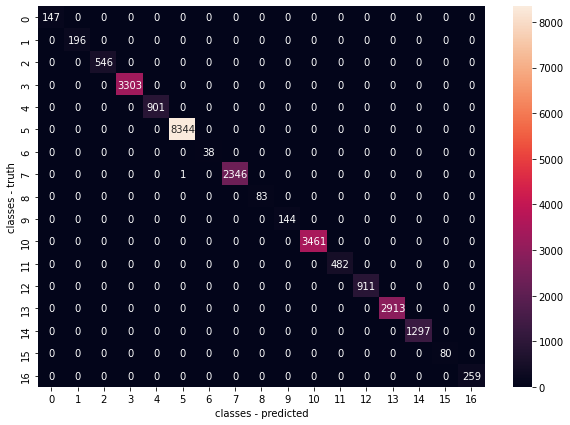

In [ ]:
cm = confusion_matrix(y,rf.predict(X))
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

In [ ]:
# from osgeo import gdal, ogr, gdal_array # I/O image data
# import numpy as np # math and array handling
# import matplotlib.pyplot as plt # plot figures
# from sklearn.ensemble import RandomForestClassifier # classifier
# import pandas as pd # handling large data as table sheets
# from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment

# import seaborn as sn

# import datetime

# # Tell GDAL to throw Python exceptions, and register all drivers
# gdal.UseExceptions()
# gdal.AllRegister()

In [ ]:
# n_cores = -1
# est = 500
# rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=1, n_jobs=n_cores)

# # verbose = 2 -> prints out every tree progression
# # rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=2, n_jobs=n_cores)



# X = np.nan_to_num(X)
# rf2 = rf.fit(X, y)

In [ ]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :np.int(img.shape[2])].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

# img_as_array = np.nan_to_num(img_as_array)

Reshaped from (4868, 7493, 4) to (36475924, 4)


In [ ]:
# a = []
# while 1:
#     a.append("1")

In [ ]:
# Now predict for each pixel
# first prediction will be tried on the entire image
# if not enough RAM, the dataset will be sliced
try:
    class_prediction = rf.predict(img_as_array)
except MemoryError:
    slices = int(round(len(img_as_array)/2))

    test = True
    
    while test == True:
        try:
            class_preds = list()
            
            temp = rf.predict(img_as_array[0:slices+1,:])
            class_preds.append(temp)
            
            for i in range(slices,len(img_as_array),slices):
                print('{} %, derzeit: {}'.format((i*100)/(len(img_as_array)), i))
                temp = rf.predict(img_as_array[i+1:i+(slices+1),:])                
                class_preds.append(temp)
            
        except MemoryError as error:
            slices = slices/2
            print('Not enought RAM, new slices = {}'.format(slices))
            
        else:
            test = False
else:
    print('Class prediction was successful without slicing!')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


In [ ]:
# concatenate all slices and re-shape it to the original extend
try:
    class_prediction = np.concatenate(class_preds,axis = 0)
except NameError:
    print('No slicing was necessary!')
    
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(class_prediction.shape))

In [ ]:
# generate mask image from red band
mask = np.copy(img[:,:,0])
mask[mask > 0.0] = 0.0 # all actual pixels have a value of 1.0

# plot mask

plt.imshow(mask)

In [ ]:
# mask classification an plot

class_prediction.astype(np.float16)
class_prediction_ = class_prediction*mask

plt.subplot(121)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)
plt.title('classification unmasked')

plt.subplot(122)
plt.imshow(class_prediction_, cmap=plt.cm.Spectral)
plt.title('classification masked')

plt.show()

In [ ]:
cols = img.shape[1]
rows = img.shape[0]

class_prediction_.astype(np.float16)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(classification_image, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(class_prediction_)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(classification_image))

In [ ]:

# validation / accuracy assessment

# preparing ttxt file

print('------------------------------------', file=open(results_txt, "a"))
print('VALIDATION', file=open(results_txt, "a"))

# laod training data from shape file
shape_dataset_v = ogr.Open(validation)
shape_layer_v = shape_dataset_v.GetLayer()
mem_drv_v = gdal.GetDriverByName('MEM')
mem_raster_v = mem_drv_v.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster_v.SetProjection(img_ds.GetProjection())
mem_raster_v.SetGeoTransform(img_ds.GetGeoTransform())
mem_band_v = mem_raster_v.GetRasterBand(1)
mem_band_v.Fill(0)
mem_band_v.SetNoDataValue(0)

# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err_v = gdal.RasterizeLayer(mem_raster_v, [1], shape_layer_v, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err_v == gdal.CE_None

roi_v = mem_raster_v.ReadAsArray()



# vizualise
plt.subplot(221)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS_Image - first band')

plt.subplot(222)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)
plt.title('Classification result')


plt.subplot(223)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Data')

plt.subplot(224)
plt.imshow(roi_v, cmap=plt.cm.Spectral)
plt.title('Validation Data')

plt.show()


# Find how many non-zero entries we have -- i.e. how many validation data samples?
n_val = (roi_v > 0).sum()
print('{n} validation pixels'.format(n=n_val))
print('{n} validation pixels'.format(n=n_val), file=open(results_txt, "a"))

# What are our validation labels?
labels_v = np.unique(roi_v[roi_v > 0])
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v))
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v), file=open(results_txt, "a"))
# Subset the classification image with the validation image = X
# Mask the classes on the validation dataset = y
# These will have n_samples rows
X_v = class_prediction[roi_v > 0]
y_v = roi_v[roi_v > 0]

print('Our X matrix is sized: {sz_v}'.format(sz_v=X_v.shape))
print('Our y array is sized: {sz_v}'.format(sz_v=y_v.shape))

# Cross-tabulate predictions
# confusion matrix
convolution_mat = pd.crosstab(y_v, X_v, margins=True)
print(convolution_mat)
print(convolution_mat, file=open(results_txt, "a"))
# if you want to save the confusion matrix as a CSV file:
#savename = 'C:\\save\\to\\folder\\conf_matrix_' + str(est) + '.csv'
#convolution_mat.to_csv(savename, sep=';', decimal = '.')

# information about precision, recall, f1_score, and support:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
#sklearn.metrics.precision_recall_fscore_support
target_names = list()
for name in range(1,(labels.size)+1):
    target_names.append(str(name))
sum_mat = classification_report(y_v,X_v,target_names=target_names)
print(sum_mat)
print(sum_mat, file=open(results_txt, "a"))

# Overall Accuracy (OAA)
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100))
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100), file=open(results_txt, "a"))

In [ ]:
cm_val = confusion_matrix(roi_v[roi_v > 0],class_prediction[roi_v > 0])
plt.figure(figsize=(10,7))
sn.heatmap(cm_val, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# # laod training data and show all shape attributes
# #model_dataset = gdal.Open(model_raster_fname)
# shape_dataset = ogr.Open(validation)
# shape_dataset = ogr.Open(training)
# shape_dataset
# shape_layer = shape_dataset.CreateLayer()

# # extract the names of all attributes (fieldnames) in the shape file
# attributes = []
# ldefn = shape_layer.GetLayerDefn()
# for n in range(ldefn.GetFieldCount()):
#     fdefn = ldefn.GetFieldDefn(n)
#     attributes.append(fdefn.name)
    
# # print the attributes
# print('Available attributes in the shape file are: {}'.format(attributes))

In [ ]:
# shape_dataset = ogr.Open(training)
# shape_layer = shape_dataset.GetLayer()

# # extract the names of all attributes (fieldnames) in the shape file
# attributes = []
# ldefn = shape_layer.GetLayerDefn()
# for n in range(ldefn.GetFieldCount()):
#     fdefn = ldefn.GetFieldDefn(n)
#     attributes.append(fdefn.name)
    
# # print the attributes
# print('Available attributes in the shape file are: {}'.format(attributes))

In [ ]:
# shp = gpd.read_file('/content/VT_KILIMO_2021-all_clean_classification_247_checking.shp')